In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.ticker as ticker
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.kernel_ridge import KernelRidge
import scipy
from scipy.constants import physical_constants

In [4]:
def h5group_to_dict(grp):
    dct = {}
    for key, val in grp.items():
        if isinstance(val, h5py.Dataset):
            dct[key] = val[()]
        else:
            dct[key] = h5group_to_dict(val)
    return dct

## Read Table

In [10]:
tab_xc = pd.read_csv("functionals.csv", encoding="UTF-8", index_col=[0])
tab_xc.year = tab_xc.year.fillna(0).astype("int32")
tab_xc = tab_xc[tab_xc["type"] != "WFT"]

In [11]:
tab_rdf = pd.concat([
    pd.read_csv("Table-RDF-dh.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-low.csv", index_col=[0], header=[0, 1])]
).loc[tab_xc.index]

In [12]:
tab_rdf_pv5z = pd.concat([
    pd.read_csv("Table-RDF-dh-pv5z.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-low-pv5z.csv", index_col=[0], header=[0, 1])]
).loc[tab_xc.index]

In [8]:
ref_etot = pd.Series({
    "B": 63.069, "C": 112.336, "N": 175.259,
    "O": 251.814, "F": 341.988, "Ne": 445.771})

In [25]:
mask_lda = tab_xc["type"] == "LDA"
mask_gga = tab_xc["type"] == "GGA"
mask_mgga = tab_xc["type"] == "mGGA"
mask_hyb_ex = ~pd.isna(tab_xc["hybrid ex"])
mask_hyb_corr = ~pd.isna(tab_xc["hybrid corr"])
mask_xdh = mask_hyb_corr & ~pd.isna(tab_xc["XYG3-type"])
mask_bdh = mask_hyb_corr & pd.isna(tab_xc["XYG3-type"])

In [28]:
mask_r3 = ~mask_hyb_ex
mask_r4 = mask_hyb_ex & ~mask_hyb_corr
mask_r5 = mask_hyb_corr

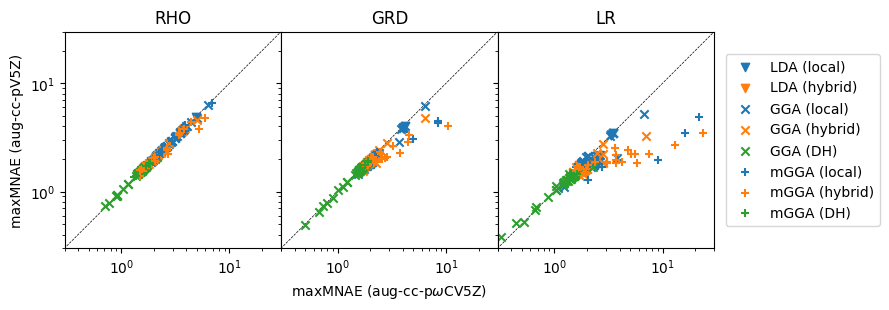

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})

def current_plot(ax, task):
    dat_pwcv5z = tab_rdf[task].T.max()
    dat_pv5z = tab_rdf_pv5z[task].T.max()
    ax.scatter(dat_pwcv5z[mask_r3 & mask_lda ], dat_pv5z[mask_r3 & mask_lda ], marker="v", color="C0", label="LDA (local)")
    ax.scatter(dat_pwcv5z[mask_r4 & mask_lda ], dat_pv5z[mask_r4 & mask_lda ], marker="v", color="C1", label="LDA (hybrid)")
    ax.scatter(dat_pwcv5z[mask_r3 & mask_gga ], dat_pv5z[mask_r3 & mask_gga ], marker="x", color="C0", label="GGA (local)")
    ax.scatter(dat_pwcv5z[mask_r4 & mask_gga ], dat_pv5z[mask_r4 & mask_gga ], marker="x", color="C1", label="GGA (hybrid)")
    ax.scatter(dat_pwcv5z[mask_r5 & mask_gga ], dat_pv5z[mask_r5 & mask_gga ], marker="x", color="C2", label="GGA (DH)")
    ax.scatter(dat_pwcv5z[mask_r3 & mask_mgga], dat_pv5z[mask_r3 & mask_mgga], marker="+", color="C0", label="mGGA (local)")
    ax.scatter(dat_pwcv5z[mask_r4 & mask_mgga], dat_pv5z[mask_r4 & mask_mgga], marker="+", color="C1", label="mGGA (hybrid)")
    ax.scatter(dat_pwcv5z[mask_r5 & mask_mgga], dat_pv5z[mask_r5 & mask_mgga], marker="+", color="C2", label="mGGA (DH)")
    
    ax.plot([0, 100], [0, 100], color="black", linewidth=0.5, linestyle="--", zorder=-1)
    ax.set_xlim(0.3, 30)
    ax.set_ylim(0.3, 30)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_box_aspect(1)
    ax.set_title(task)

for ax, task in zip(axs, ["RHO", "GRD", "LR"]):
    current_plot(ax, task)

axs[2].legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
axs[1].set_xlabel("maxMNAE (aug-cc-p$\omega$CV5Z)")
axs[0].set_ylabel("maxMNAE (aug-cc-pV5Z)")
fig.tight_layout()
fig.savefig("../basisdep-RDF.pdf", transparent=True)

In [14]:
tab_rdf["RHO"].T.max()

functional
Slater      4.864004
SVWN        3.725131
SVWN1RPA    3.631283
VWN1RPA     3.650341
VWN5        3.539821
              ...   
r++SCAN     2.055890
R2SCAN0     2.058658
R2SCAN50    2.020525
R4SCAN      2.076695
R4SCAN0     2.042890
Length: 173, dtype: float64